In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib 
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import BatchNormalization, Concatenate,concatenate
from keras.models import load_model
from keras.optimizers import Adam
from keras.layers import Input
from keras.models import Model
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import seaborn as sn

Using TensorFlow backend.


## Iperparametri

In [2]:
use_layer_regression = False
learning_rate = 0.001
logIndex = 19
dropout_rate = 0.5

hidden_layers = [100, 100]
n_output = 1

batch_size = 10
iterations = 50

## Ottiene i dati

In [3]:
df = pd.read_csv('patterns.csv')
#print(df.head(5))

#ottiene gli input ed li divide in dummy variables
X1 = pd.get_dummies(df.iloc[:, 0]).values.astype(np.float32)
X2 = pd.get_dummies(df.iloc[:, 24]).values.astype(np.float32)
for i in range(1,24):
    X1_dummy = pd.get_dummies(df.iloc[:, i]).values.astype(np.float32)
    X2_dummy = pd.get_dummies(df.iloc[:, i+24]).values.astype(np.float32)
    X1 = np.concatenate((X1, X1_dummy), axis=1)
    X2 = np.concatenate((X2, X2_dummy), axis=1)

#ottiene gli output e li trasforma in classi    
y = df.iloc[:, -1].values.astype(np.float32)

#separa dati di train da dati di test
test_size=0.33
X1_train, X1_test, X2_train, X2_test, y_train, y_test = train_test_split(X1, X2, y, test_size=test_size, random_state=42)

X_train = np.concatenate((X1_train, X2_train), axis=1)
X_test = np.concatenate((X1_test, X2_test), axis=1)

y_train = y_train/200
y_test = y_test/200

## Crea il modello ed effettua il training

In [5]:
n_input = X1_train.shape[1]
input1 = Input((n_input,))
input2 = Input((n_input,))
layer = concatenate([input1, input2], axis=1)
layer = Dropout(dropout_rate)(layer)
layer = Activation('relu')(layer)
    
for i in range(len(hidden_layers)):
    #aggiunge lo strato nascosto
    layer = Dense(hidden_layers[i])(layer)
    layer = Dropout(dropout_rate)(layer)
    layer = Activation('relu')(layer)
    
#aggiunge lo strato di uscita
output = Dense(n_output)(layer)

#crea il modello
model = Model([input1, input2], output)

#compila la rete neurale
optimizer = Adam(lr=learning_rate)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])

#addestra la rete neurale
history = model.fit([X1_train, X2_train], y_train, batch_size=batch_size, epochs=iterations, validation_data=([X1_test, X2_test], y_test), verbose=1)


Train on 1339 samples, validate on 660 samples
Epoch 1/50
1339/1339 [==============================] - 1s 406us/step - loss: 0.3564 - mean_absolute_error: 0.4586 - val_loss: 0.0603 - val_mean_absolute_error: 0.2093
Epoch 2/50
1339/1339 [==============================] - 0s 167us/step - loss: 0.1051 - mean_absolute_error: 0.2543 - val_loss: 0.0715 - val_mean_absolute_error: 0.2331
Epoch 3/50
1339/1339 [==============================] - 0s 159us/step - loss: 0.0640 - mean_absolute_error: 0.2023 - val_loss: 0.0603 - val_mean_absolute_error: 0.2106
Epoch 4/50
1339/1339 [==============================] - 0s 158us/step - loss: 0.0454 - mean_absolute_error: 0.1687 - val_loss: 0.0537 - val_mean_absolute_error: 0.1968
Epoch 5/50
1339/1339 [==============================] - 0s 162us/step - loss: 0.0394 - mean_absolute_error: 0.1608 - val_loss: 0.0448 - val_mean_absolute_error: 0.1774
Epoch 6/50
1339/1339 [==============================] - 0s 161us/step - loss: 0.0322 - mean_absolute_error: 0.145

## Stampa le perdite

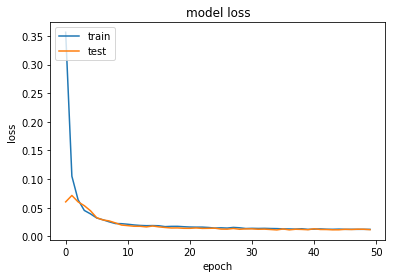

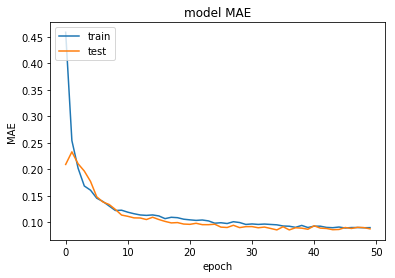

In [6]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for accuracy
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Valuta il modello in base alla regressione

In [7]:
#ottiene le predictions dal modello
predictions = model.predict([X1_test, X2_test]).flatten()*200
labels = y_test*200

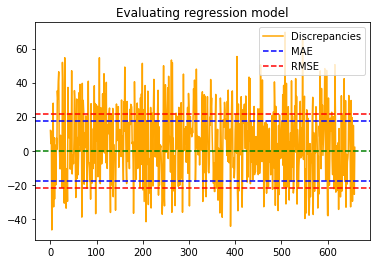

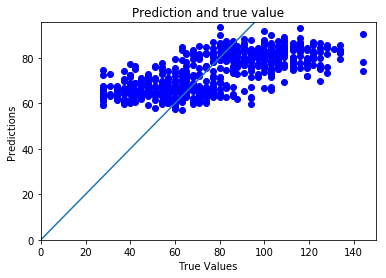

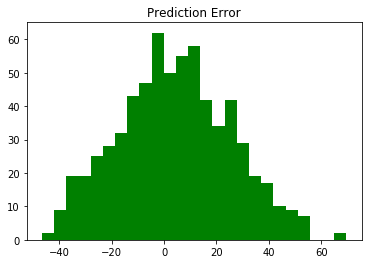

MAE:  17.576141  (→ 0)
RMSE:  21.79188100832187  (→ 0)
R^2:  0.31563749539146047  (→ 1)


In [8]:
#ottiene l' R^2 score (ottimo valore se tendente a 1)
r_square = r2_score(labels, predictions) 

#ottiene il Mean Absolute Error (MAE) (ottimo valore se tendente a 0)
mae = mean_absolute_error(labels, predictions)

#ottiene il Root Mean Squared Error (RMSE) (ottimo valore se tendente a 0)
rmse = mean_squared_error(labels, predictions)**0.5

#stampa le varie discrepanze (differenza tra il valore atteso ed il valore predetto)
discrepancies = []
for i in range(len(labels)):
    discrepancies.append(labels[i]-predictions[i])
plt.title('Evaluating regression model')
plt.plot(discrepancies, label='Discrepancies', color='orange')
plt.axhline(y=mae, color='b', linestyle='--', label='MAE')
plt.axhline(y=-mae, color='b', linestyle='--')
plt.axhline(y=rmse, color='r', linestyle='--', label='RMSE')
plt.axhline(y=-rmse, color='r', linestyle='--')
plt.axhline(y=-0, color='g', linestyle='--')
plt.legend(loc='upper right')
plt.show()

#predictions e true value
plt.scatter(labels, predictions, color='blue')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Prediction and true value')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
plt.plot([-500, 500], [-500, 500])
plt.show()

#distribuzione degli errori
plt.hist(discrepancies, bins=25, color='green')
plt.title("Prediction Error")
plt.show()

#stampa i risultati
print("MAE: ", mae, " (→ 0)")
print("RMSE: ", rmse, " (→ 0)")
print("R^2: ", r_square, " (→ 1)")

## Valuta il modello in base alla classificazione

In [9]:
#trasforma le predizioni in classi
def transformToClass(yr):
    yc = []
    for i in range(len(yr)):
        yi = np.zeros(7)
        if (yr[i]<70):                  yi[0] = 1 #A
        if (yr[i]>=70  and yr[i]<=83) : yi[1] = 1 #B
        if (yr[i]>=84  and yr[i]<=98) : yi[2] = 1 #C
        if (yr[i]>=99  and yr[i]<=113): yi[3] = 1 #D
        if (yr[i]>=114 and yr[i]<=128): yi[4] = 1 #E
        if (yr[i]>=129 and yr[i]<=143): yi[5] = 1 #F
        if (yr[i]>143):                 yi[6] = 1 #G
        yc.append(yi)
    yr = np.array(yc)
    return yr


c_labels = transformToClass(labels)
c_predictions = transformToClass(predictions)

accuracy_score: 0.4015
precision_score: 0.3433
recall_score: 0.4015
f1_score: 0.3612


C:\Users\Utente\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Utente\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


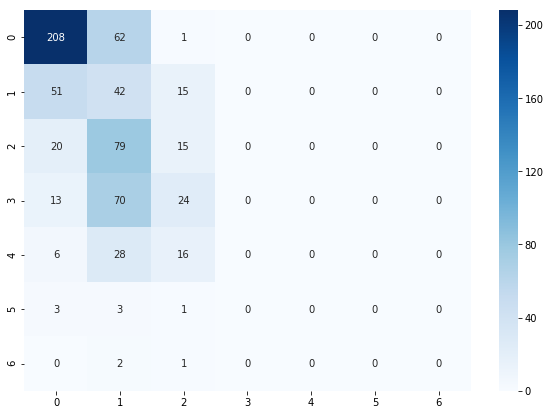

In [10]:

#valuta la classificazione
predictions_max = np.argmax(c_predictions, axis=1)
y_test_max = np.argmax(c_labels, axis=1)

#calcola gli score
accuracy_score_val = accuracy_score(y_test_max, predictions_max)
precision_score_val = precision_score(y_test_max, predictions_max, average='weighted') # tp / (tp + fp)
recall_score_val = recall_score(y_test_max, predictions_max, average='weighted') # tp / (tp + fn)
f1_score_val = f1_score(y_test_max, predictions_max, average='weighted')

#stampa gli score
print("accuracy_score: %0.4f" % accuracy_score_val)
print("precision_score: %0.4f" % precision_score_val)
print("recall_score: %0.4f" % recall_score_val)
print("f1_score: %0.4f" % f1_score_val)

#ottiene e stampa la confusion matrix
cm = confusion_matrix(y_test_max, predictions_max)
df_cm = pd.DataFrame(cm, 
                     index = [i for i in range(cm.shape[0])],
                     columns = [i for i in range(cm.shape[1])])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')